In [1]:
import numpy as np
import math
from math import erf, sqrt
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
import ipywidgets as widgets
import datetime

In [2]:
# Read in data from the basin.txt file or the basin_collect.txt file
# adjust data_collect notebook to changes dates or file names

def read_basin_data(filename):
    """
    Expects lines of the form:
      YYYY Mon DD HH:MM  Temp(F) MxTp MnTp Dew(F) RH(%) Spd(mph?) Dir Gst SWIN SWOUT LWIN LWOUT NET
    For example:
      2025 Mar 20 20:00  13      20   0   -1   55   6  259 15   0    1    195  252   -60
    Columns (0-based indexing):
      0=Year,1=Month,2=Day,3=HH:MM,
      4=Temp(F?),5=MxTp,6=MnTp,7=Dew(F),8=RH(%),
      9=Spd,10=Dir,11=Gst,12=SWIN,13=SWOUT,14=LWIN,15=LWOUT,16=NET

    Creates arrays for:
      - date/time -> hours since earliest row
      - T (F)
      - dew point (°F)
      - RH (%)
      - wind speed (assuming mph => converted to m/s, or directly m/s if data says so)
      - SW_in, SW_out, LW_in, LW_out, net
    """

    month_map = {
        'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
        'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12
    }

    times_list       = []
    T_airF_list      = []
    dew_list         = []
    RH_list          = []
    wind_spd_list    = []
    SW_in_list       = []
    SW_out_list      = []
    LW_in_list       = []
    LW_out_list      = []
    NET_list         = []

    earliest_time = None

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 17:
                continue

            # date/time
            year_str, month_str, day_str = parts[0], parts[1], parts[2]
            hhmm_str = parts[3]
            try:
                year  = int(year_str)
                month = month_map[month_str]
                day   = int(day_str)
            except ValueError:
                continue

            hh_part, mm_part = hhmm_str.split(':')
            hour_24 = int(hh_part)
            minute  = int(mm_part)
            # if "24:00" => treat as 00:00 next day
            if hour_24 == 24:
                hour_24 = 0
                date_obj = datetime.datetime(year, month, day) + datetime.timedelta(days=1)
                year, month, day = date_obj.year, date_obj.month, date_obj.day

            row_time = datetime.datetime(year, month, day, hour_24, minute)
            if earliest_time is None or row_time < earliest_time:
                earliest_time = row_time

            try:
                # parse key columns
                T_valF   = float(parts[4])     # Temp in F
                dew_val  = float(parts[7])     # Dew point, F
                rh_val   = float(parts[8])     # RH in %
                spd_val  = float(parts[9])     # wind speed,  mph 
                sw_in    = float(parts[12])
                sw_out   = float(parts[13])
                lw_in    = float(parts[14])
                lw_out   = float(parts[15])
                net_val  = float(parts[16])
            except ValueError:
                continue

            times_list.append(row_time)
            T_airF_list.append(T_valF)
            dew_list.append(dew_val)
            RH_list.append(rh_val)
            wind_spd_list.append(spd_val)
            SW_in_list.append(sw_in)
            SW_out_list.append(sw_out)
            LW_in_list.append(lw_in)
            LW_out_list.append(lw_out)
            NET_list.append(net_val)

    if len(times_list) == 0:
        raise ValueError("No valid data parsed from file.")

    # convert times to hours since earliest
    times_arr = np.zeros(len(times_list))
    for i, t in enumerate(times_list):
        dt = t - earliest_time
        times_arr[i] = dt.total_seconds()/3600.0

    T_airF_arr     = np.array(T_airF_list)
    dew_arr        = np.array(dew_list)
    RH_arr         = np.array(RH_list)
    wind_spd_arr   = np.array(wind_spd_list)
    SW_in_arr      = np.array(SW_in_list)
    SW_out_arr     = np.array(SW_out_list)
    LW_in_arr      = np.array(LW_in_list)
    LW_out_arr     = np.array(LW_out_list)
    NET_arr        = np.array(NET_list)

    # sort chronologically
    idx_sort = np.argsort(times_arr)
    times_arr   = times_arr[idx_sort]
    T_airF_arr  = T_airF_arr[idx_sort]
    dew_arr     = dew_arr[idx_sort]
    RH_arr      = RH_arr[idx_sort]
    wind_spd_arr= wind_spd_arr[idx_sort]
    SW_in_arr   = SW_in_arr[idx_sort]
    SW_out_arr  = SW_out_arr[idx_sort]
    LW_in_arr   = LW_in_arr[idx_sort]
    LW_out_arr  = LW_out_arr[idx_sort]
    NET_arr     = NET_arr[idx_sort]

    return (times_arr, T_airF_arr, dew_arr, RH_arr, wind_spd_arr,
            SW_in_arr, SW_out_arr, LW_in_arr, LW_out_arr, NET_arr)



In [3]:
# Phyical constants and parameters
sigma      = 5.67e-8    # Stefan-Boltzmann constant
eps_snow   = 0.98        # Snow emissivity
snow_depth_m = 2.0      # Total snow thickness
N = 100                 # Number of uniform layers
h_conv = 10.0           # Not currently used, but available
c_snow = 2100.0         # Snow specific heat (J/kg.K)
rho_snow = 200.0        # Snow density (kg/m^3)
rho_air  = 1.2          # Air density (kg/m^3)
c_pa     = 1005.0       # Specific heat of air at const. pressure (J/kg.K)
Lv_subl  = 2.83e6       # Latent heat of sublimation (J/kg)
g        = 9.81         # Gravity (m/s^2) [not directly used, but common]
z_ref    = 2.0          # Reference height (m) for measurements
k        = 0.2          # Snow thermal conductivity (W/m.K)
Lf       = 3.34e5       # Latent heat of fusion (J/kg)
alpha_snow = 0.85       # Not used in this snippet, but common for reflectivity

# Turbulent flux exchange coefficients
CH = 0.001  # Sensible heat
CE = 0.001 # Latent heat

use_twoBand = True      # If True, use two-band SW absorption approach
n_days = 3              # Simulation length (days)
dt_max = 90             # Max solver step (seconds)

In [4]:
# Read in data from the basin.txt file or the basin_collect.txt file
filename = "/Users/austinfinnell/Documents/GitHub//finalproject/basin_collect.txt"
times_arr, T_air_arr, dew_arr, RH_arr, wind_spd_arr, sw_in_arr, sw_out_arr, lw_in_arr, lw_out_arr, net_arr = read_basin_data(filename)
 
lw_out_surf_temp_K = (lw_out_arr / (eps_snow * sigma))**0.25
lw_out_surf_temp_C = lw_out_surf_temp_K - 273.15

times_sec = times_arr*3600
surf_temp_obs_interp = interp1d(times_sec, lw_out_surf_temp_C, kind='linear', fill_value='extrapolate')

# Convert wind speed array from mph to m/s:
mph_to_ms = 0.44704
wind_ms_arr = wind_spd_arr * mph_to_ms

# Build interpolation for each
T_airF_interp  = interp1d(times_sec, T_air_arr,  kind='linear', fill_value='extrapolate')
dew_arr_interp = interp1d(times_sec, dew_arr,     kind='linear', fill_value='extrapolate')
RH_arr_interp  = interp1d(times_sec, RH_arr,      kind='linear', fill_value='extrapolate')
wind_interp    = interp1d(times_sec, wind_ms_arr, kind='linear', fill_value='extrapolate')
SW_in_interp   = interp1d(times_sec, sw_in_arr,   kind='linear', fill_value='extrapolate')
SW_out_interp  = interp1d(times_sec, sw_out_arr,  kind='linear', fill_value='extrapolate')
LW_in_interp   = interp1d(times_sec, lw_in_arr,   kind='linear', fill_value='extrapolate')
LW_out_interp  = interp1d(times_sec, lw_out_arr,  kind='linear', fill_value='extrapolate')


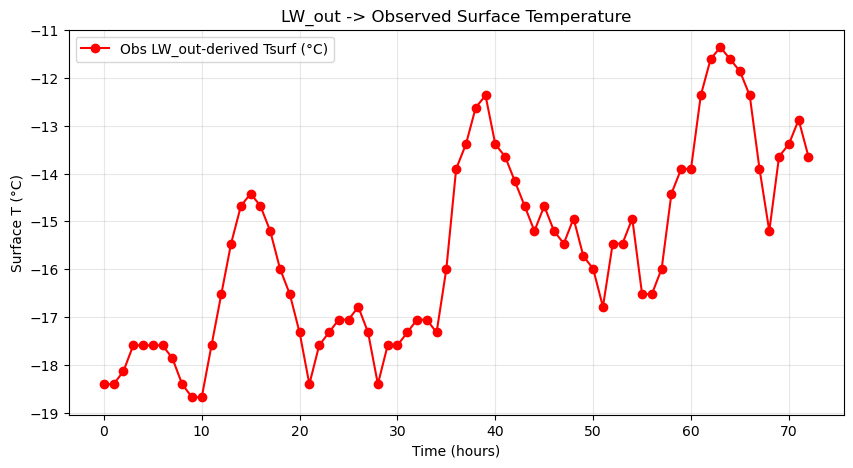

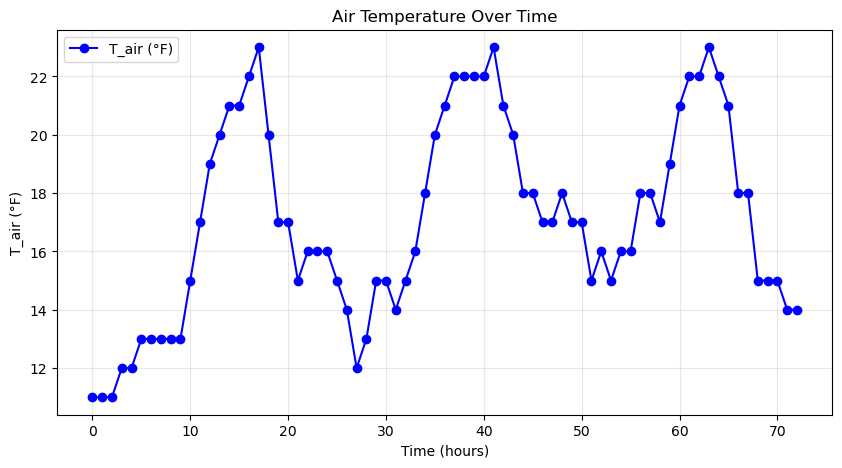

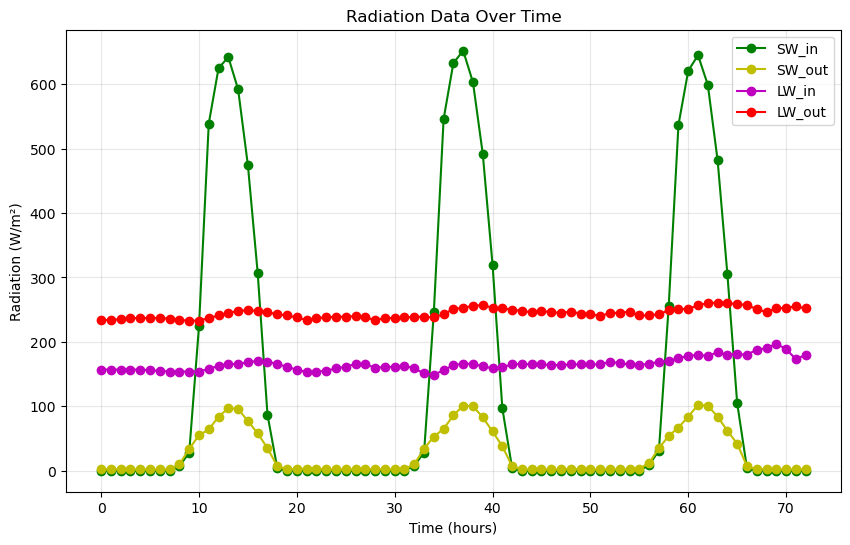

In [5]:
# Plot observed data if True 

show_plots = True  

if show_plots:
    # Plot the observed surface temperature from LW_out
    plt.figure(figsize=(10, 5))
    plt.plot(times_arr, lw_out_surf_temp_C, 'ro-', label='Obs LW_out-derived Tsurf (°C)')
    plt.xlabel("Time (hours)")
    plt.ylabel("Surface T (°C)")
    plt.title("LW_out -> Observed Surface Temperature")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Plot the air temperature over time
    plt.figure(figsize=(10, 5))
    plt.plot(times_arr, T_air_arr, 'bo-', label='T_air (°F)')
    plt.xlabel("Time (hours)")
    plt.ylabel("T_air (°F)")
    plt.title("Air Temperature Over Time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Plot the radiation data
    plt.figure(figsize=(10, 6))
    plt.plot(times_arr, sw_in_arr, 'go-', label='SW_in')
    plt.plot(times_arr, sw_out_arr, 'yo-', label='SW_out')
    plt.plot(times_arr, lw_in_arr, 'mo-', label='LW_in')
    plt.plot(times_arr, lw_out_arr, 'ro-', label='LW_out')
    plt.xlabel("Time (hours)")
    plt.ylabel("Radiation (W/m²)")
    plt.title("Radiation Data Over Time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [6]:
# Set up grid and the initial temperature profile

z_F = np.linspace(0.0, snow_depth_m, N+1)   # N+1 faces for N layers
z_T = 0.5*(z_F[:-1] + z_F[1:])              # Layer midpoints
dz  = z_F[1:] - z_F[:-1]                    # Thickness of each layer
H   = z_F[-1]                               # Should match snow_depth_m

print(f"Snow Depth = {H:.3f} m with {N} layers; each ~{dz[0]:.4f} m thick")

T_ground       = 273.15
T_snow_min     = lw_out_surf_temp_K[0]      # top layer initial
decay_factor   = -4.0
temp_diff      = T_ground - T_snow_min
normalized_dep = z_T / H
exp_term       = (1 - np.exp(decay_factor*normalized_dep)) / (1 - np.exp(decay_factor))
T_init         = T_ground - temp_diff*exp_term

# Overwrite the very top layer with the first observed surface temp
T_init[-1] = T_snow_min



Snow Depth = 2.000 m with 100 layers; each ~0.0200 m thick


In [7]:
# Functions 

def measured_air_temp(t_sec):
    # Convert measured T_air from F to C to K
    T_F = T_airF_interp(t_sec)
    T_C = (T_F - 32.0)*(5.0/9.0)
    return T_C + 273.15

def get_wind_speed(t_sec):
    # Wind speed is from data and already converted to m/s
    return wind_interp(t_sec) 

# def compute_specific_humidity(T_C, RH, p=85000):
#     e_sat = 611 * np.exp((17.27 * T_C) / (T_C + 237.3))  # saturation vapor pressure in Pa
#     e_act = RH * e_sat  # actual vapor pressure in Pa
#     return (0.622 * e_act) / (p - (0.378 * e_act))  # specific humidity

# def get_air_specific_humidity(t_sec):
#     T_airK = measured_air_temp(t_sec)
#     T_airC = T_airK - 273.15
#     RH = RH_arr_interp(t_sec) / 100.0
#     return compute_specific_humidity(T_airC, RH)

# def get_snow_specific_humidity(T_surfK, p=85000):
#     T_surfC = T_surfK - 273.15
#     e_snow_sat = 611.0 * np.exp((22.46 * T_surfC) / (T_surfC + 272.62))  # saturation vapor pressure over ice
#     return (0.622 * e_snow_sat) / (p - (0.378 * e_snow_sat))

def turbulent_fluxes(t_sec, T_surfK):
    T_airK = measured_air_temp(t_sec)
    U = get_wind_speed(t_sec)
    Q_sensible = rho_air * c_pa * CH * U * (T_airK - T_surfK)  
    
    # q_air = get_air_specific_humidity(t_sec)
    # q_snow = get_snow_specific_humidity(T_surfK)
    Q_latent   = 0 #rho_air * Lv_subl * CE * U * (q_air - q_snow) 
    # scale_factor =  0.0005 # (Was 1e-3 ~ 0.001) just to bring Pa -> kPa or an approximate scale
    # Q_latent   = rho_air * Lv_subl * CE * U * (e_air - e_snow) * scale_factor

    return Q_sensible, Q_latent

def separate_radiation(t_sec, T_surfK):
    # downward radiation is positive, upward is negative
    lw_down = LW_in_interp(t_sec)
    #lw_up   = -LW_out_interp(t_sec)
    lw_up_model = eps_snow * sigma * (T_surfK**4)
    lw_up = -lw_up_model
    sw_down = SW_in_interp(t_sec)
    sw_up   = -SW_out_interp(t_sec)

    lw_net = lw_down + lw_up
    sw_net = max(sw_down + sw_up, 0)
    return lw_net, sw_net

def surface_flux_dataDriven(t_sec, T_surfK):
    """
    Return only the flux at the top from longwave + sensible + latent.
    We handle shortwave in the snow interior to avoid double-counting.
    """
    lw_net, _ = separate_radiation(t_sec, T_surfK)
    Q_sensible, Q_latent = turbulent_fluxes(t_sec, T_surfK)
    return lw_net + Q_sensible + Q_latent

def shortwave_absorption_profile_twoBand(t_sec, z_faces):
    """
    Splits net shortwave flux into two bands:
      - Near-IR: fraction f_nir with attenuation kappa_nir (very shallow penetration)
      - Visible: fraction f_vis = 1 - f_nir with attenuation kappa_vis (deeper penetration)

    The absorption is computed using a coordinate d = H - z (depth below the surface),
    so that energy is deposited primarily in the upper snowpack.
    """
    # 1) Compute the net shortwave at the surface
    sw_net = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0) # issues with out being more than in and setting to 0 

    # 2) Set spectral fractions and attenuation coefficients
    f_nir = 0.5      
    kappa_nir = 20.0  # high attenuation: energy absorbed very near the surface

    f_vis = 1.0 - f_nir
    kappa_vis = 3.0  # lower attenuation: energy penetrates deeper

    # 3) Compute top-of-snow flux in each band
    sw_nir_top = sw_net * f_nir
    sw_vis_top = sw_net * f_vis

    # 4) Compute absorption for each layer using depth below the surface.
    # Here, d = H - z, with H the total snowpack thickness and z from z_faces.
    n_layers = len(z_faces) - 1
    SW_abs_nir = np.zeros(n_layers)
    SW_abs_vis = np.zeros(n_layers)
    for i in range(N):
        # Instead of using z directly, convert layer boundaries to depth below surface:
        d_top = H - z_faces[i+1]    # shallow boundary (closer to the surface, d near 0)
        d_bottom = H - z_faces[i]   # deeper boundary (larger d)
        
        # near-IR flux entering and exiting the layer
        flux_in_nir  = sw_nir_top * np.exp(-kappa_nir * d_top)
        flux_out_nir = sw_nir_top * np.exp(-kappa_nir * d_bottom)
        SW_abs_nir[i] = flux_in_nir - flux_out_nir

        # visible flux entering and exiting the layer
        flux_in_vis  = sw_vis_top * np.exp(-kappa_vis * d_top)
        flux_out_vis = sw_vis_top * np.exp(-kappa_vis * d_bottom)
        SW_abs_vis[i] = flux_in_vis - flux_out_vis

    # 5) Total shortwave absorption in each layer is the sum of both bands.
    SW_abs_2band = SW_abs_nir + SW_abs_vis
    
    # # Verify energy conservation
    # total_absorbed = np.sum(SW_abs_2band)
    # if total_absorbed > 0 and abs(total_absorbed - sw_net) > 0.01:
    #     SW_abs_2band = SW_abs_2band * (sw_net / total_absorbed)
        
    return SW_abs_2band


def enforce_melt_freeze(T, dTdt):
    melt_water = np.zeros(N)  # Track melted water in each layer
    
    for i in range(N):
        if T[i] > 273.15:
            # Calculate overshoot energy
            overshoot_dT = T[i] - 273.15
            layer_mass = dz[i] * rho_snow  # kg per m^2
            energy_overshoot = overshoot_dT * layer_mass * c_snow
            
            # Convert to melt water
            melt_water[i] = energy_overshoot / Lf
            
            # Set temperature to freezing point
            T[i] = 273.15
            
            # Allow energy to continue moving through the layer
            # instead of zeroing dTdt completely
            if dTdt[i] > 0:
                dTdt[i] = 0.0  # Only zero out warming rates, not cooling
        
    return T, dTdt



In [8]:
# Solver 

def dT_dt(t_sec, T):
    spin_up_duration = 3600
    ramp = min(1.0, t_sec / spin_up_duration)
    
    F = np.zeros(N+1)
    # conduction at bottom
    F[0] = k*(T_ground - T[0])/dz[0]
    for i in range(1,N):
        F[i] = k*(T[i-1]-T[i])/dz[i]

    # surface flux
    net_surf = surface_flux_dataDriven(t_sec, T[-1])
    F[N] = -net_surf

    dTdt = np.zeros(N)
    for i in range(N):
        dTdt[i] = -(F[i+1] - F[i])/(rho_snow*c_snow*dz[i])

    if use_twoBand:
        SW_profile = shortwave_absorption_profile_twoBand(t_sec, z_F)
    else:
        SW_profile = shortwave_absorption_profile_surface(t_sec, z_F)   
    
    for i in range(N):
        dTdt[i] += (SW_profile[i] / (rho_snow * c_snow * dz[i]))
        
    T, dTdt = enforce_melt_freeze(T, dTdt)
    
    return dTdt

In [9]:

# Solve

n_days = 3
t_end = n_days*24*3600
dt_max = 60

sol = solve_ivp(fun=dT_dt,
                t_span=(0, t_end),
                y0=T_init,
                method='RK45',
                max_step=dt_max)
time = sol.t
T_layers = sol.y
print(f"Integration done with {len(time)} time steps over {t_end/3600} hours.")


Integration done with 4323 time steps over 72.0 hours.


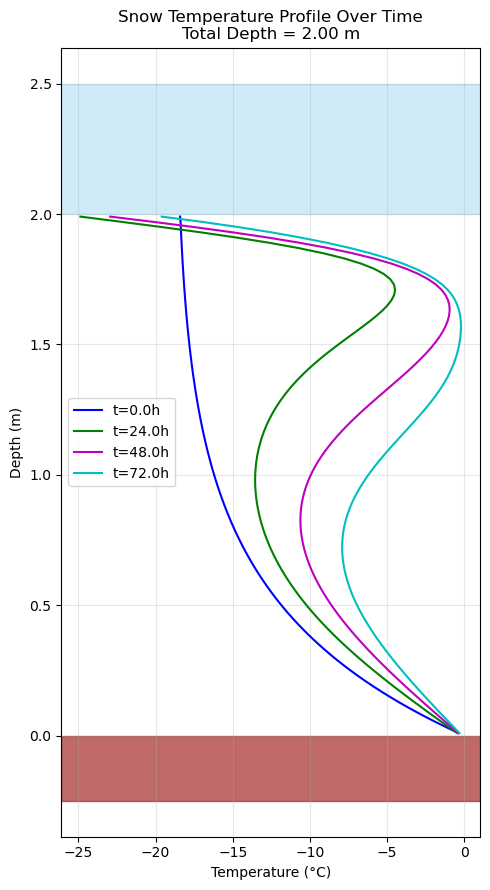

In [10]:
final_temp = T_layers[:,-1]
plt.figure(figsize=(5,9))

n_snaps = 4
snap_ids = np.linspace(1, len(time)-2, n_snaps, dtype=int)
colors   = ['b','g','m','c']
for i, idx in enumerate(snap_ids):
    T_s  = T_layers[:, idx] - 273.15
    t_hrs= time[idx]/3600
    plt.plot(T_s, z_T, color=colors[i], label=f"t={t_hrs:.1f}h")

plt.axhspan(-0.25, 0, color='brown', alpha=0.7)
plt.axhspan(H, H+0.5, color='skyblue', alpha=0.4)
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title(f"Snow Temperature Profile Over Time\nTotal Depth = {H:.2f} m")
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

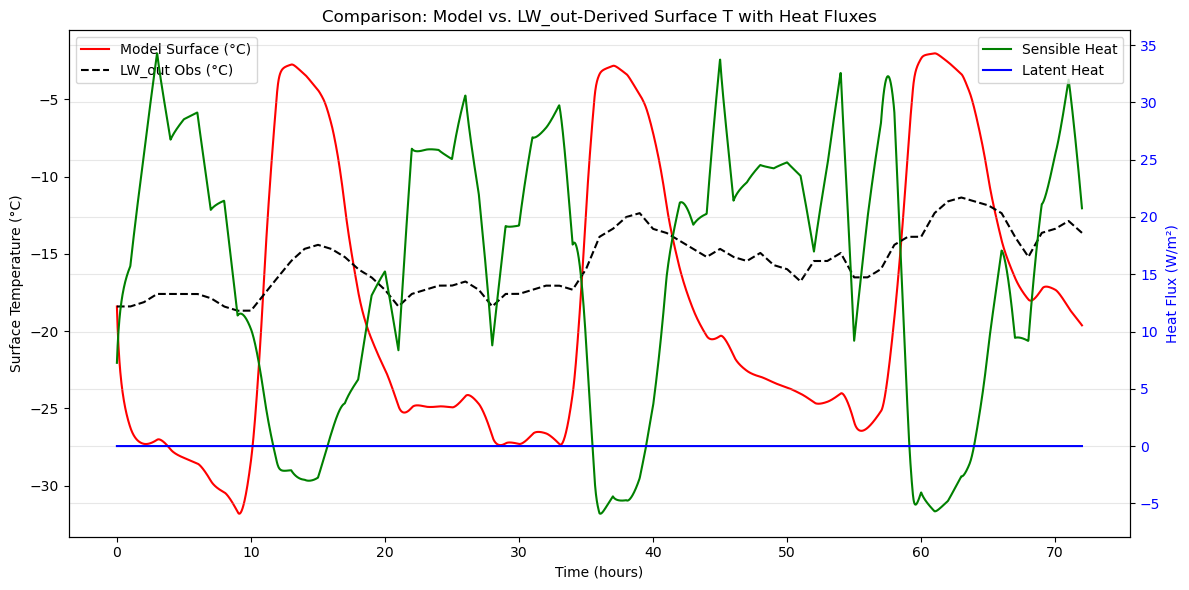

In [11]:

# ------------------------------------------------------------------------------
# Compare Observed vs. Model at Surface
# ------------------------------------------------------------------------------
model_time_sec   = sol.t
model_surf_tempC = T_layers[-1,:] - 273.15
obs_surf_tempC   = surf_temp_obs_interp(model_time_sec)

# Calculate sensible and latent heat fluxes for plotting
Q_sensible_arr = []
Q_latent_arr = []
total_flux_arr = []
time_hours = model_time_sec/3600

for i, t in enumerate(model_time_sec):
    T_surf = T_layers[-1, i]  # Surface temperature at time t
    Q_sensible, Q_latent = turbulent_fluxes(t, T_surf)
    Q_sensible_arr.append(Q_sensible)
    Q_latent_arr.append(Q_latent)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot surface temperatures on the first y-axis
ax1.plot(time_hours, model_surf_tempC, 'r-', label='Model Surface (°C)')
ax1.plot(time_hours, obs_surf_tempC, 'k--', label='LW_out Obs (°C)')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Surface Temperature (°C)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Create second y-axis for heat fluxes
ax2 = ax1.twinx()
ax2.plot(time_hours, Q_sensible_arr, 'g-', label='Sensible Heat')
ax2.plot(time_hours, Q_latent_arr, 'b-', label='Latent Heat')
# ax2.plot(time_hours, total_flux_arr, 'm-', label='Total Flux')
ax2.set_ylabel("Heat Flux (W/m²)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

plt.title("Comparison: Model vs. LW_out-Derived Surface T with Heat Fluxes")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



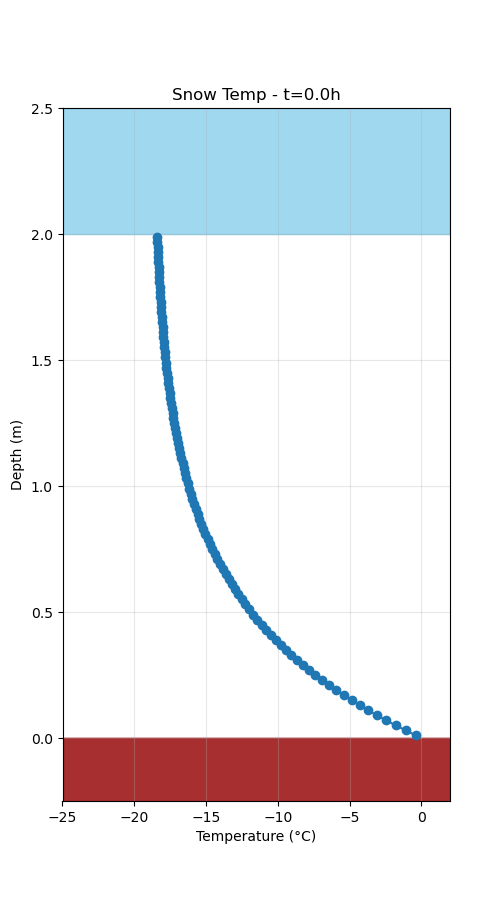

In [12]:
# Create a gif animation 

fig, ax = plt.subplots(figsize=(5,9))
line, = ax.plot([],[],'-o')

def init_anim():
    ax.set_xlim(-25, 2)
    ax.set_ylim(-0.25, H+0.5)
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Depth (m)")
    ax.set_title("Snow Temperature Profile Evolution")
    ax.grid(True, alpha=0.3)
    ax.axhspan(-0.25,0, color='brown', alpha=0.7)
    ax.axhspan(H,H+0.5, color='skyblue', alpha=0.4)
    return line,

def animate(i):
    idx = int(i*len(time)/100)
    if idx>=len(time):
        idx=len(time)-1
    T_s = T_layers[:, idx]-273.15
    hrs= time[idx]/3600
    ax.set_title(f"Snow Temp - t={hrs:.1f}h")
    line.set_data(T_s, z_T)
    return line,

ani = FuncAnimation(fig, animate, frames=101,
                    init_func=init_anim, interval=100, blit=True)
ani.save('temperature_profile_evolution.gif', writer='pillow', fps=5)
plt.close()
display(Image('temperature_profile_evolution.gif'))


In [13]:
print("DEBUG SUMMARY:")
print("Hour, t_sec, SW_in, SW_out, LW_in, LW_out, net_rad, air_temp(K), wind(m/s), "
      "Q_sensible, Q_latent, QH, net_surf_flux, cond_bottom, cond_top, "
      "SW_topLayer, SW_total_abs, measured_albedo, model_top_T(°C), obs_top_T(°C), diff_T(°C)")

last_valid_albedo = alpha_snow  # fallback albedo

for hr in range(n_days * 24 + 1):
    t_sec = hr * 3600.0

    # Raw input data from radiation sensors:
    sw_in = SW_in_interp(t_sec)
    sw_out = SW_out_interp(t_sec)
    lw_in = LW_in_interp(t_sec)
    lw_out = LW_out_interp(t_sec)
    
    # Compute net radiation (W/m²)
    net_rad = (sw_in - sw_out) + (lw_in - lw_out)
    
    # Environmental variables:
    air_tempK = measured_air_temp(t_sec)
    wind_speed = get_wind_speed(t_sec)
    
    # Interpolate temperature profile (in Kelvin)
    T_now = np.array([func(t_sec) for func in layer_temp_funcs])
    
    # Compute fluxes using our helper function:
    fluxes = compute_debug_fluxes(t_sec, T_now)
    cond_bottom = fluxes["F"][0]
    cond_top = fluxes["F"][-1]
    Q_sensible = fluxes["Q_sensible"]
    Q_latent = fluxes["Q_latent"]
    QH = fluxes["QH"]
    net_surf_flux = fluxes["net_surf_flux"]
    sw_profile = fluxes["SW_profile"]
    sw_top_layer = sw_profile[-1]
    sw_total_abs = np.sum(sw_profile)
    
    # Compute measured albedo from SW data:
    if sw_in > 0:
        measured_albedo = sw_out / sw_in
        # Enforce an upper limit if needed, for example:
        if measured_albedo > 1.0:
            measured_albedo = 1.0
        last_valid_albedo = measured_albedo
    else:
        measured_albedo = last_valid_albedo

    # Surface temperature: model (from top layer) and observation (from LW_out derived)
    model_top_T = T_now[-1] - 273.15
    obs_top_T = surf_temp_obs_interp(t_sec)
    diff_T = model_top_T - obs_top_T

    # Print the debug line (CSV format)
    print(f"{hr}, {t_sec:.2f}, {sw_in:.2f}, {sw_out:.2f}, {lw_in:.2f}, {lw_out:.2f}, {net_rad:.2f}, "
          f"{air_tempK:.2f}, {wind_speed:.2f}, {Q_sensible:.2f}, {Q_latent:.2f}, {QH:.2f}, {net_surf_flux:.2f}, "
          f"{cond_bottom:.2f}, {cond_top:.2f}, {sw_top_layer:.2f}, {sw_total_abs:.2f}, {measured_albedo:.3f}, "
          f"{model_top_T:.2f}, {obs_top_T:.2f}, {diff_T:.2f}")


DEBUG SUMMARY:
Hour, t_sec, SW_in, SW_out, LW_in, LW_out, net_rad, air_temp(K), wind(m/s), Q_sensible, Q_latent, QH, net_surf_flux, cond_bottom, cond_top, SW_topLayer, SW_total_abs, measured_albedo, model_top_T(°C), obs_top_T(°C), diff_T(°C)


NameError: name 'layer_temp_funcs' is not defined